In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import datetime
import matplotlib.pyplot as plt
import numpy
from readSelfTrackerSheet import *

In [2]:
sheet = RetrieveSpreadSheet()

In [3]:
 SetUp(sheet)

Please indicate in semicolon seperated format who the desired trainees are.

	ie "Gamboa,Allan"; "Basior,Greg";...

	If all trainees are desired say:

	"all"

	Available Trainees are:

	Garvey
	Pittman
	Griffin
	Perkins
	Rowlett
	Warner
	Jestes
	Helwig
	Curnutt
	Frye
	Vaughan
all
Please provide the begin date in "M/D/YYYY" format (ie 5/11/1989) to filter
	"all"	if you dont want to filter:all


In [4]:
GetListOfTraineeObjects()

Creating Object For garvey
Creating Object For pittman
Creating Object For griffin
Creating Object For perkins
Creating Object For rowlett
Creating Object For warner
Creating Object For jestes
Creating Object For helwig
Creating Object For curnutt
Creating Object For frye
Creating Object For vaughan


In [5]:
FilterTraineesDateRanges()

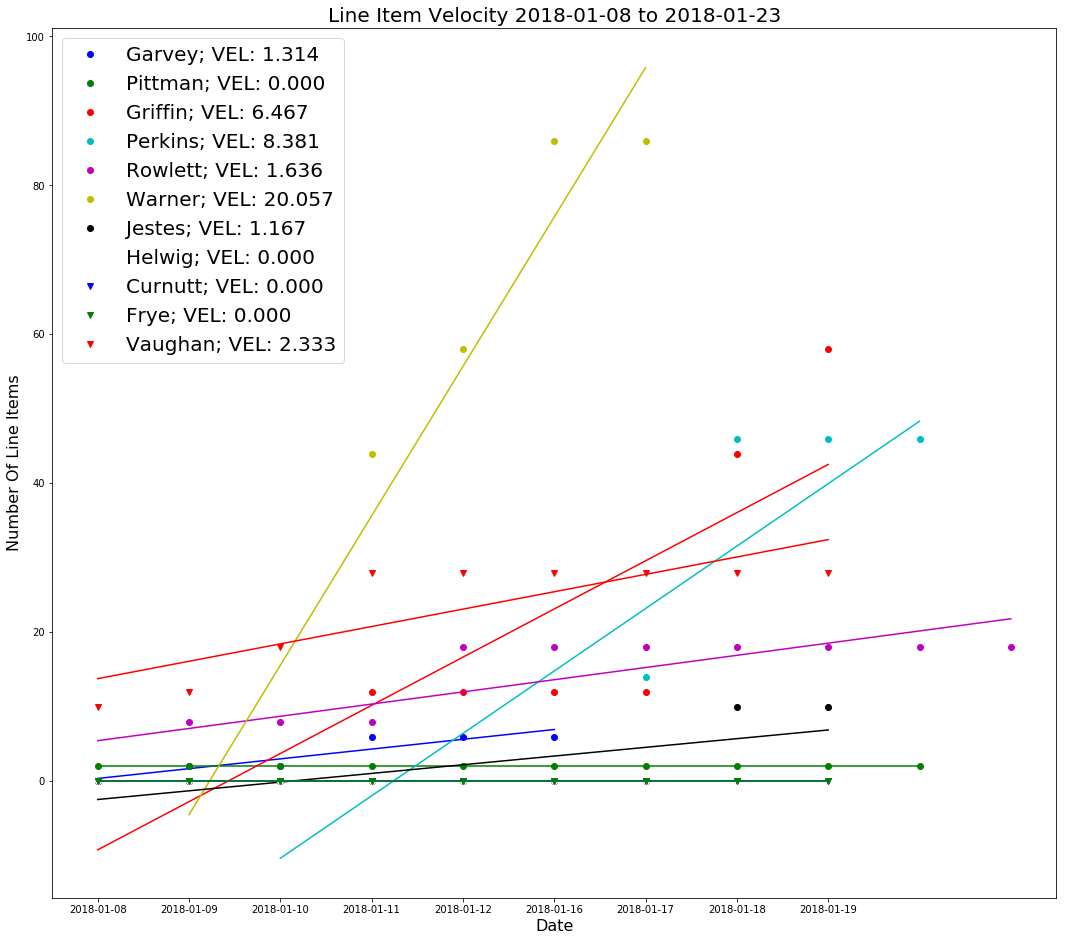

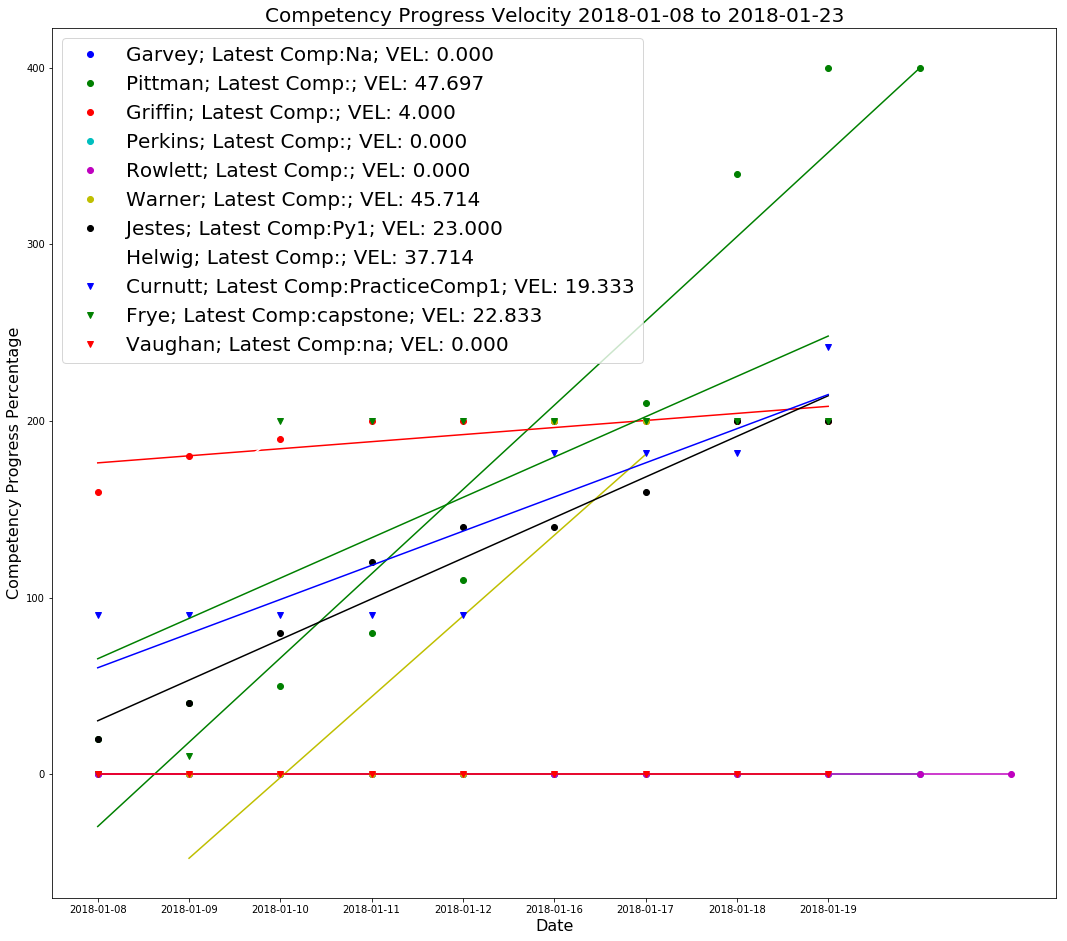

In [6]:
MakePlots()
   

In [7]:
CreateTableOfVelocities()


Line Velocity ML:	Mean = 3.760	STD = 5.800
Comp Velocity ML:	Mean = 18.208	STD = 18.041
Line Velocity AVG:	Mean = 1.527	STD = 2.090
Comp Velocity AVG:	Mean = 9.872	STD = 8.470

      NAME          LINE ITEM       LINE ITEM     COMP PROGRESS   COMP PROGRESS    LINE ITEMS         COMPS     
                  VELOCITY ML    VELOCITY AVG    VELOCITYM ML    VELOCITY AVG      COMPLETED       COMPLETED   
    Garvey           1.314           0.500           0.000           0.000             3               0       
    Pittman          0.000           0.100           47.697          20.000            1               2       
    Griffin          6.467           3.222           4.000           11.111           29               1       
    Perkins          8.381           2.875           0.000           0.000            23               1       
    Rowlett          1.636           0.818           0.000           0.000             9               0       
    Warner           20.057          

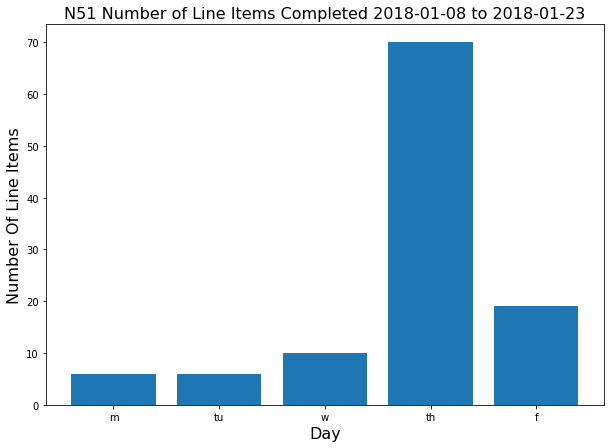

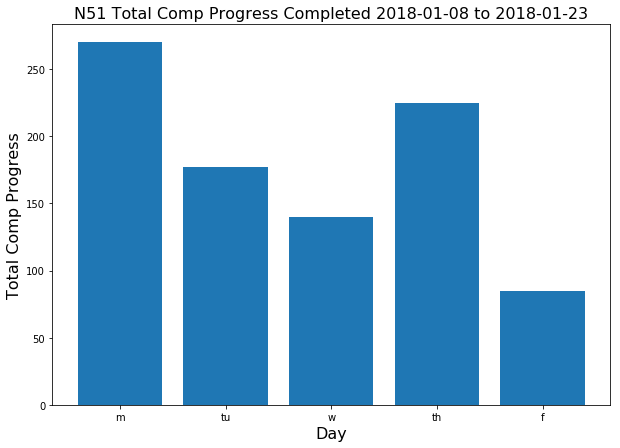

In [8]:
CreateDayOfWeekDistributions()

In [9]:
UpdateJQRTracker(selfTrackerSheetName='JQR Self Progress',
                     historicalTrackerSheetName='Historical Training Tracker',
                     targetSheetName='Target Training Tracker')

Creating count object for  Garvey.
Self Tracker Sections/Comps:
{'201': 0, '200': 3, '101': 0, '204': 0, '100': 0, '202': 0, 'Debug': 0}
{'Python \nComps': 0, 'Assembly \nComps': 0, 'C Comps': 0, 'Capstone \nProject': 0}
Historical Sections/Comps:
{'201': 0, '200': 0, '101': 0, '204': 0, '100': 17, '202': 0, 'Debug': 0}
{'Python \nComps': 0, 'Assembly \nComps': 0, 'C Comps': 0, 'Capstone \nProject': 0}
Press <ENTER> to continue with update.
Updating Garvey.

Creating count object for  Pittman.
Self Tracker Sections/Comps:
{'201': 0, '200': 1, '101': 0, '204': 0, '100': 0, '202': 0, 'Debug': 0}
{'Python \nComps': 0, 'Assembly \nComps': 0, 'C Comps': 2, 'Capstone \nProject': 0}
Historical Sections/Comps:
{'201': 16, '200': 0, '101': 5, '204': 0, '100': 17, '202': 0, 'Debug': 7}
{'Python \nComps': 0, 'Assembly \nComps': 0, 'C Comps': 2, 'Capstone \nProject': 0}
Press <ENTER> to continue with update.
Updating Pittman.

Creating count object for  Griffin.
Self Tracker Sections/Comps:
{'201'

In [2]:
l = [['apple', 'banana', 'orange'], ['toyota', 'bmw', 'jaguar'], ['allan']]

In [6]:
for i in l:
    for j in i:
        print(j)

apple
banana
orange
toyota
bmw
jaguar
allan


In [8]:
for i in reversed(l):
    for j in reversed(i):
        print(j)

allan
jaguar
bmw
toyota
orange
banana
apple
